# Cell cycle label transfer

In this notebook we show how to use transmorph and leverage optimal transport to perform label transfer between cells.

## Data loading

In [3]:
from transmorph.datasets import load_cell_cycle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

datasets = load_cell_cycle()

databank_api > Loading bank cell_cycle.
databank_api > Bank cell_cycle successfully loaded.


In [15]:
def scatter_plot(figure, datasets, obsm_rep, obs_class=None, mode="class", legend_on_plot=False, legendtitle=None):
    if not isinstance(datasets, dict):
        datasets = {"": datasets}
    X_tot = np.zeros((0,2))
    y_dataset = np.zeros((0,))
    y_class = np.zeros((0,))
    for name, dataset in datasets.items():
        X_tot = np.concatenate((X_tot, dataset.obsm[obsm_rep]), axis=0)
        y_dataset = np.concatenate((y_dataset, [name]*dataset.n_obs), axis=0)
        if obs_class is not None:
            y_class = np.concatenate((y_class, dataset.obs[obs_class]), axis=0)
        
    if mode == "class":
        y = y_class
    else:
        assert mode == "dataset", f"unrecognized mode: {mode}"
        y = y_dataset
        
    ax = figure.add_subplot(111)
    for label in sorted(set(y)):
        if label == 'NotAssigned':
            continue
        selector = y == label
        X = X_tot[selector]
        ax.scatter(*X.T, label=label, s=2)
        if legend_on_plot:
            bbox_opt = {
                "facecolor": "white", 
                "edgecolor": "white", 
                "alpha": 0.5, 
                "pad": 0
            }
            plt.text(
                *X.mean(axis=0), 
                label, 
                size="small",
                ha="center", 
                va="center", 
                bbox=bbox_opt
            )
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    if obs_class is not None:        
        # Add a legend
        plt.legend(
            markerscale=5,
            fontsize=14
        )

def label_transfer(
    adatas,
    ref_adata,
    obs_label: str,
    use_rep: str = "transmorph",
    n_neighbors: int = 10
) -> None:
    """
    Transfers ref_adata labels onto all AnnDatas after integration via nearest neighbors.
    """
    if isinstance(adatas, dict):
        adatas = adatas.values()
    nn = NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(ref_adata.obsm[use_rep])
    all_labels = set(ref_adata.obs[obs_label])
    # For each non-U2OS AnnData, we transfer U2OS labels onto it using
    # k-nearest neighbors.
    for adata in adatas:
        if adata is ref_adata:
            continue
        indices = nn.kneighbors(adata.obsm[use_rep], return_distance=False)
        prediction = []
        prediction_confidence = []
        for i in range(adata.n_obs):
            labels = np.array(ref_adata.obs[obs_label][indices[i]])
            counts = {l: 0 for l in all_labels}
            for label in labels:
                if label not in counts:
                    counts[label] = 0
                counts[label] += 1
            top_label = max(counts.keys(), key=lambda k: counts[k])
            prediction.append(top_label)
            prediction_confidence.append([counts[l]/sum(counts.values()) for l in all_labels])
        prediction_confidence = np.array(prediction_confidence)
        adata.obs[obs_label] = prediction
        adata.obsm[f'{obs_label} (confidence)'] = prediction_confidence

In [16]:
# TC71 and U2OS are "fast" cell cycle datasets.
# Using these genes for G1/S signature yields clearer
# visualizations.
fast_cell_cycle_g1s = [
    'CDK1', 'UBE2C', 'TOP2A', 'TMPO', 'HJURP', 'RRM1',
    'RAD51AP1', 'RRM2', 'CDC45', 'BLM', 'BRIP1', 'E2F8', 'HIST2H2AC'
]

for name, adata in datasets.items():
    g1s = adata.var_names[adata.var['G1/S gene']]
    g2m = adata.var_names[adata.var['G2/M gene']]
    if name in ["TC71", "U2OS"]:
        g1s = [g for g in g1s if g in fast_cell_cycle_g1s]
    cc_coordinates = np.zeros((adata.n_obs, 2))
    cc_coordinates[:, 0] = adata[:, g1s].X.mean(axis=1)
    cc_coordinates[:, 1] = adata[:, g2m].X.mean(axis=1)
    # Filtering out a few outliers
    adata.obsm['cell_cycle'] = cc_coordinates
    datasets[name] = adata[cc_coordinates[:, 1] > -2, :].copy()

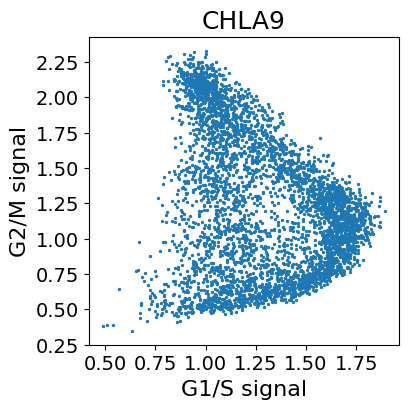

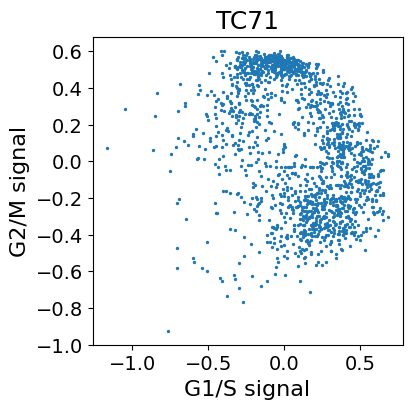

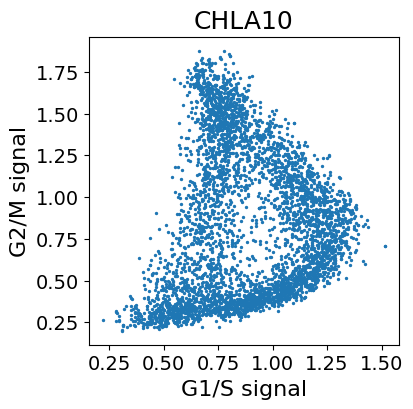

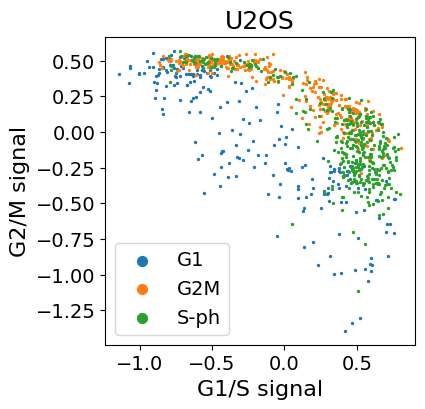

In [17]:
for name, adata in datasets.items():
    obs = None
    mode = 'dataset'
    if name == 'U2OS':
        obs = 'Cell cycle phase'
        mode = 'class'
    figure = plt.figure(figsize=(4,4))
    scatter_plot(figure, adata, 'cell_cycle', mode=mode, obs_class=obs)
    plt.xlabel('G1/S signal', fontsize=16)
    plt.ylabel('G2/M signal', fontsize=16)
    plt.title(name, fontsize=18)

## With optimal transport

In [ ]:
# Loading and fitting the model
from transmorph.models import TransportCorrection

# use_feature_space=True returns a result in  the original genes space
model = TransportCorrection(
    solver="unbalanced",
    use_feature_space=True,
    entropy_epsilon=2e-2, # These two parameters should be tweaked
    unbalanced_reg=5.0
)
model.transform(datasets, reference=datasets["CHLA10"], output_representation="otcorrection")

In [19]:
# TC71 and U2OS are "fast" cell cycle datasets.
# Using these genes for G1/S signature yields clearer
# visualizations.
fast_cell_cycle_g1s = [
    'CDK1', 'UBE2C', 'TOP2A', 'TMPO', 'HJURP', 'RRM1',
    'RAD51AP1', 'RRM2', 'CDC45', 'BLM', 'BRIP1', 'E2F8', 'HIST2H2AC'
]

embedding_genes = model.embedding_features
g1s_indices = datasets['CHLA10'][:, embedding_genes].var['G1/S gene'].to_numpy()
g2m_indices = datasets['CHLA10'][:, embedding_genes].var['G2/M gene'].to_numpy()

for name, adata in datasets.items():
    cc_coordinates = np.zeros((adata.n_obs, 2))
    cc_coordinates[:, 0] = adata.obsm['otcorrection'][:, g1s_indices].mean(axis=1)
    cc_coordinates[:, 1] = adata.obsm['otcorrection'][:, g2m_indices].mean(axis=1)
    # Filtering out a few outliers
    adata.obsm['corrected_cell_cycle_ot'] = cc_coordinates

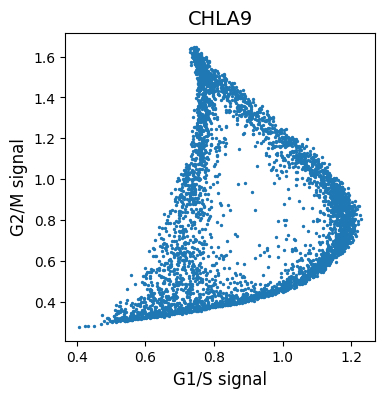

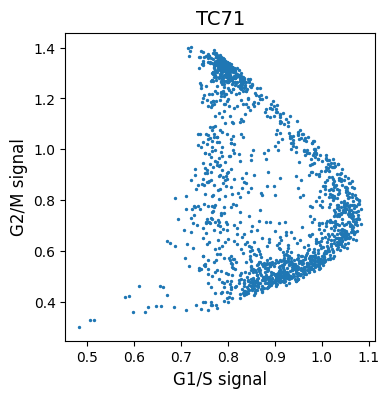

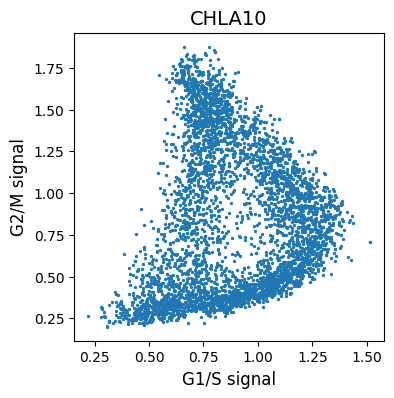

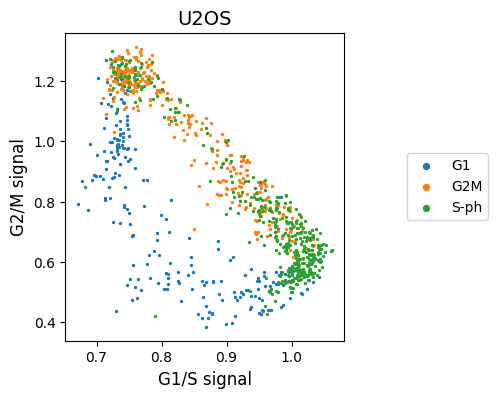

In [7]:
for name, adata in datasets.items():
    obs = None
    mode = 'dataset'
    if name == 'U2OS':
        obs = 'Cell cycle phase'
        mode = 'class'
    figure = plt.figure(figsize=(4,4))
    scatter_plot(figure, adata, 'corrected_cell_cycle_ot', mode=mode, obs_class=obs)
    plt.xlabel('G1/S signal', fontsize=12)
    plt.ylabel('G2/M signal', fontsize=12)
    plt.title(name, fontsize=14)

In [20]:
label_transfer(datasets, datasets['U2OS'], 'Cell cycle phase', use_rep="otcorrection")

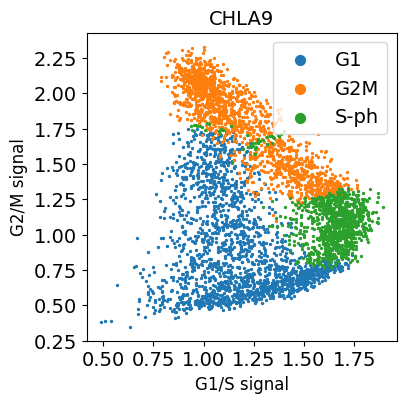

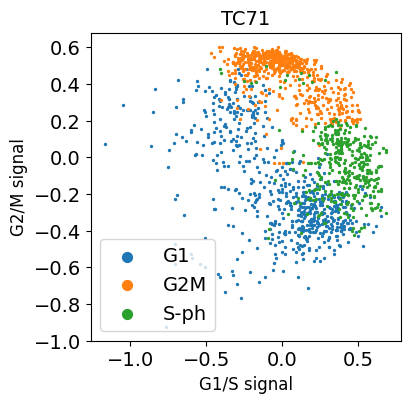

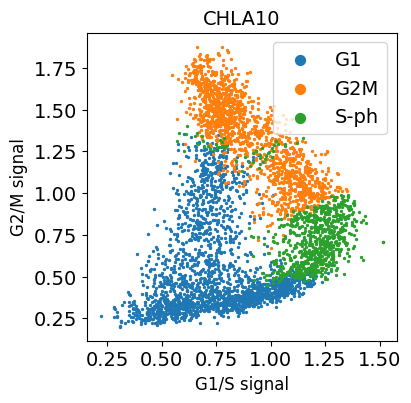

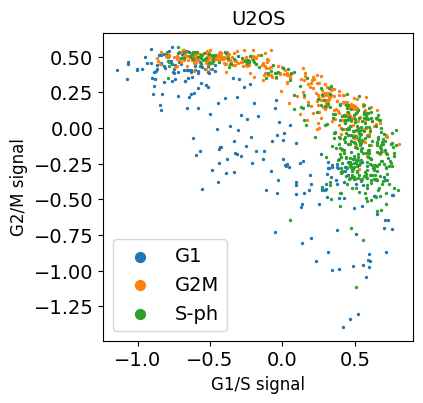

In [21]:
for name, adata in datasets.items():
    obs = 'Cell cycle phase'
    mode = 'class'
    figure = plt.figure(figsize=(4,4))
    scatter_plot(figure, adata, 'cell_cycle', mode=mode, obs_class=obs)
    plt.xlabel('G1/S signal', fontsize=12)
    plt.ylabel('G2/M signal', fontsize=12)
    plt.title(name, fontsize=14)

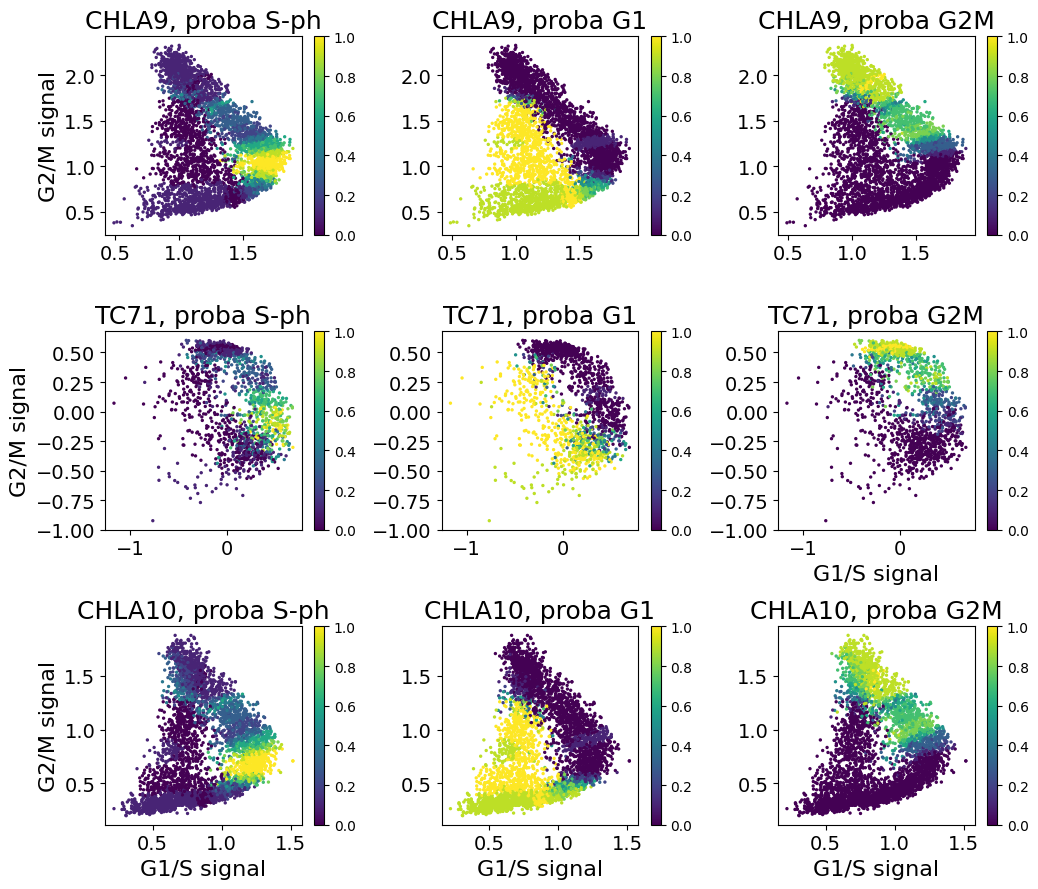

In [31]:
figure = plt.figure(figsize=(10.5, 9))
nplot = 0
for name, adata in datasets.items():
    if name == 'U2OS':
        continue
    obs = 'Cell cycle phase'
    for i, label in enumerate(set(datasets['U2OS'].obs[obs])):
        if label == 'NotAssigned':
            continue
        nplot += 1
        plt.subplot(3,3,nplot)
        plt.scatter(
            *adata.obsm['cell_cycle'].T, 
            c=adata.obsm['Cell cycle phase (confidence)'][:, i], 
            s=2, 
            vmin=0.0,
            vmax=1.0
        )
        if nplot >= 6:
            plt.xlabel('G1/S signal', fontsize=16)
        if (nplot % 3) == 1:
            plt.ylabel('G2/M signal', fontsize=16)
        plt.title(f'{name}, proba {label}', fontsize=18)
        cbar = plt.colorbar()
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
plt.tight_layout()

## With MNN

In [ ]:
# Loading and fitting the model
from transmorph.models import MNNCorrection

# use_feature_space=True returns a result in  the original genes space
model = MNNCorrection()
model.transform(datasets, reference=datasets["CHLA10"], output_representation="mnncorrection")

In [11]:
# TC71 and U2OS are "fast" cell cycle datasets.
# Using these genes for G1/S signature yields clearer
# visualizations.
fast_cell_cycle_g1s = [
    'CDK1', 'UBE2C', 'TOP2A', 'TMPO', 'HJURP', 'RRM1',
    'RAD51AP1', 'RRM2', 'CDC45', 'BLM', 'BRIP1', 'E2F8', 'HIST2H2AC'
]

embedding_genes = model.embedding_features
g1s_indices = datasets['CHLA10'][:, embedding_genes].var['G1/S gene'].to_numpy()
g2m_indices = datasets['CHLA10'][:, embedding_genes].var['G2/M gene'].to_numpy()

for name, adata in datasets.items():
    cc_coordinates = np.zeros((adata.n_obs, 2))
    cc_coordinates[:, 0] = adata.obsm['mnncorrection'][:, g1s_indices].mean(axis=1)
    cc_coordinates[:, 1] = adata.obsm['mnncorrection'][:, g2m_indices].mean(axis=1)
    # Filtering out a few outliers
    adata.obsm['corrected_cell_cycle_mnn'] = cc_coordinates

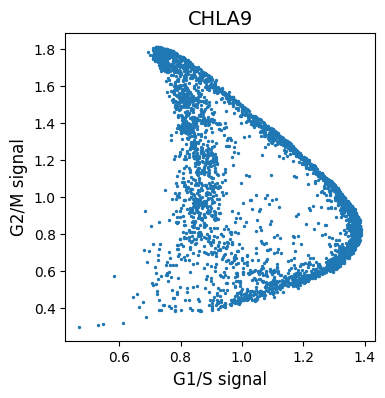

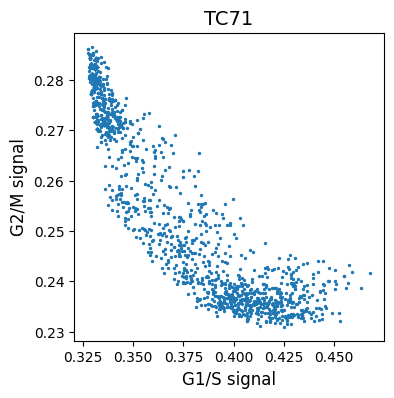

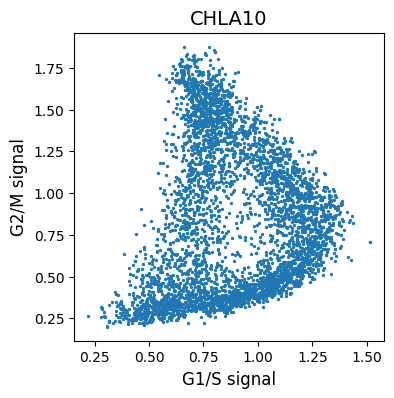

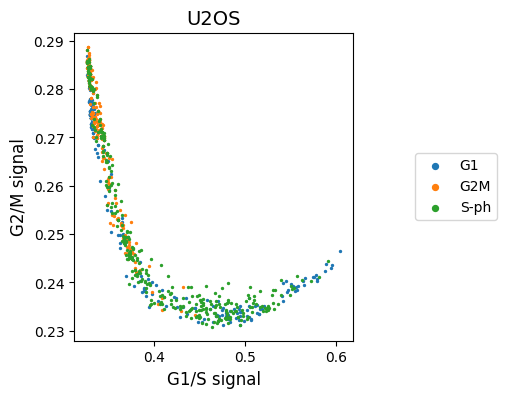

In [12]:
for name, adata in datasets.items():
    obs = None
    mode = 'dataset'
    if name == 'U2OS':
        obs = 'Cell cycle phase'
        mode = 'class'
    figure = plt.figure(figsize=(4,4))
    scatter_plot(figure, adata, 'corrected_cell_cycle_mnn', mode=mode, obs_class=obs)
    plt.xlabel('G1/S signal', fontsize=12)
    plt.ylabel('G2/M signal', fontsize=12)
    plt.title(name, fontsize=14)

In [13]:
label_transfer(datasets, datasets['U2OS'], 'Cell cycle phase', use_rep="mnncorrection")

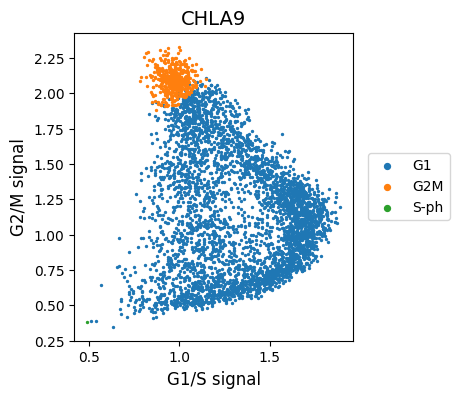

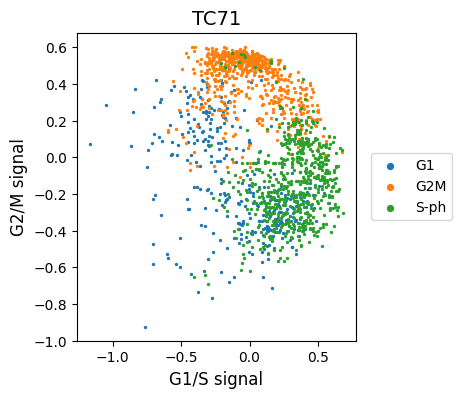

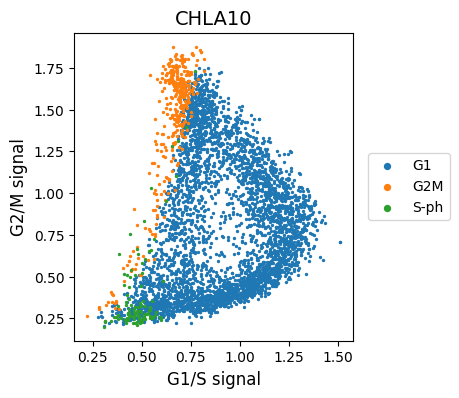

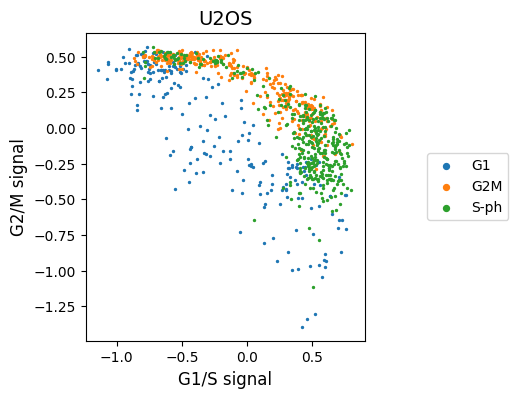

In [14]:
for name, adata in datasets.items():
    obs = 'Cell cycle phase'
    mode = 'class'
    figure = plt.figure(figsize=(4,4))
    scatter_plot(figure, adata, 'cell_cycle', mode=mode, obs_class=obs)
    plt.xlabel('G1/S signal', fontsize=12)
    plt.ylabel('G2/M signal', fontsize=12)
    plt.title(name, fontsize=14)